<a href="https://colab.research.google.com/github/mitsuogui/Face-Recognition-Proyect-Talller/blob/main/I_Etapa_FR_face_recognition_estudiantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico de Costa Rica
### Reconocimiento de Rostros
Authores:
###Juan Pablo González Ramírez  
###Marco Antonio Quirós Cabezas

Note: When using this notebook, you must select a GPU Hardware Accelerator instead of CPU. Go to Runtime->Change Runtime Type and select any option that uses GPU.

# Dependencies

In [1]:
!pip install face_recognition         # Install face_recognition package using pip



import face_recognition
import cv2                            # Import OpenCV
import numpy as np
from matplotlib import pyplot as plt  # pyplot

# ipywidgets packages
import ipywidgets as widgets
from IPython.display import display, clear_output


# Live Streaming dependencies
from IPython.display import Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

# Importar la librería datetime para poder manejar fechas
import datetime

import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566171 sha256=38aacf1268918100d67b0073d93b8ba1f36044be429b531cb61726a17b9e8452
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


# Utils

## In-memory data

In [2]:
registered_faces = {}

In [56]:
from google.colab import drive
drive.mount('/content/sample_data/ProyectP')

Mounted at /content/sample_data/ProyectP


## face recognition

In [4]:
def check_if_face_registered(face_encoding):
  for _, registered_face in registered_faces.items():
    if True in face_recognition.compare_faces([face_encoding], registered_face):
      return True
  return False

## Real time streaming

In [7]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 800, 600);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 800; //video.videoWidth;
      captureCanvas.height = 600; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

In [8]:
# JavaScript code to stop the webcam stream
js_stop_stream = """
    const stream = video.srcObject;
    const tracks = stream.getTracks();

    tracks.forEach(function(track) {
        track.stop();
    });

    video.srcObject = null;
    div.style.display = 'none';  // Hide the container
"""

# Function to stop the video streaming
def stop_video_stream():
    display(Javascript(js_stop_stream))

# Register Faces

In [9]:
# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Recognize Faces

<IPython.core.display.Javascript object>

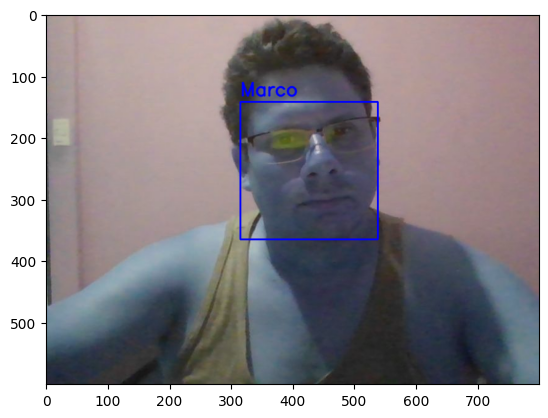

In [92]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
bbox = ''

while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  # convert JS response to OpenCV Image
  frame = js_to_image(js_reply["img"])

  # Get the face locations from the frame
  face_locations = face_recognition.face_locations(frame)

  # For each face in the frame
  for (top, right, bottom, left) in face_locations:
      # Draw a rectangle around the face
      cv2.rectangle(
          frame,
          (left, top),
          (right, bottom),
          (0, 0, 255),
          2,
      )
      # Get the face encoding of the face
      face_encoding = face_recognition.face_encodings(frame, [(top, right, bottom, left)])[0]

      # Compare the face encoding to the faces in the database
      matches = face_recognition.compare_faces(list(registered_faces.values()), face_encoding)

      # If there is a match
      if True in matches:
          # Get the index of the match
          match_index = matches.index(True)

          # Get the name of the match
          match_name = list(registered_faces.keys())[match_index]

          # Draw the name of the match on the frame
          cv2.putText(
              frame,
              match_name,
              (left, top - 10),
              cv2.FONT_HERSHEY_SIMPLEX,
              1,
              (0, 0, 255),
              2,
              cv2.LINE_AA,
          )
      else:
          # Draw unknown on the frame
          cv2.putText(
              frame,
              "Unknown",
              (left, top - 10),
              cv2.FONT_HERSHEY_SIMPLEX,
              1,
              (0, 0, 255),
              2,
              cv2.LINE_AA,
          )

  # Show image
  plt.imshow(frame)
  plt.show()

In [93]:
#CLASE 8
print(match_name)

Marco


# Professors list

In [15]:

# Define a function to obtain the professor's information
def add_professor():
    """
    The function `add_professor()` prompts the user to enter information about a professor, including
    their ID, name, birthday, nationality, phone numbers, emails, home address, speciality, years in the
    institution, and personal vehicle license plate, and returns a dictionary with the professor's
    information.
    :return: a dictionary containing the professor's information.
    """
    # Request Id
    id = input("Enter Id: ")

    # Request Name
    name = input("Enter professor`s name: ")
    # Ask if the name is in registered face's list

    if name not in registered_faces:
      print("Professor's face not found in registered faces database.")
      return None


    # Request birthday
    birthday = input("Enter the birthday (mm/dd/yyyy): ")

    # Request Nationality
    nationality = input("Enter Nationality: ")

    # Request phone numbers
    phone_numbers = []
    print("Enter phone numbers, one per line. To finish, press Enter on an empty line")
    while True:
        enter_phone_numbers = input("Enter phone number, one per line. To finish, press Enter on an empty line: ")
        if enter_phone_numbers == "":
            break
        phone_numbers.append(enter_phone_numbers)

    # Request emails
    emails = []
    print("Enter emails, one per line. To finish, press Enter on an empty line.")
    while True:
        email = input("Enter email: ")
        if email == "":
            break
        emails.append(email)

    # Request home direction
    address = input("Enter home address: ")

    # Request speciality
    speciality = input("Enter speciality: ")

    # Request years in institution
    years_in_institution = int(input("Enter years in institution: "))

    # Request personal vehicle license plate
    vehicle_license_plate = input("Enter your personal vehicle license plate (N/A if the professor do not have a vehicle): ")


    # Create a dictionary with the professor's information
    prof_info = {
        "identification": id,
        "name": name,
        "birthday": datetime.datetime.strptime(birthday, "%m/%d/%Y").date(),
        "nationality": nationality,
        "phone numbers": phone_numbers,
        "emails": emails,
        "home address": address,
        "speciality": speciality,
        "years in the institution": years_in_institution,
        "personal vehicle license plate": vehicle_license_plate
    }

    # Return the dictionary with the professor's information
    return prof_info

# Generate the list of professors
prof_list = []

# Request professors information
while True:
    # Get information from a professor
    prof_info = add_professor()

    # Add professor information to the professor list
    prof_list.append(prof_info)

    # Ask if the user want's to add another professor
    option = input("Do you want to add another professor? (y/n): ")
    if option != "y":
        break

# Imprimir la lista de profesores
for prof_info in prof_list:
    print(prof_info)


Enter Id: 1111
Enter professor`s name: Strange
Enter the birthday (mm/dd/yyyy): 01/01/1988
Enter Nationality: usa
Enter phone numbers, one per line. To finish, press Enter on an empty line
Enter phone number, one per line. To finish, press Enter on an empty line: 11889977
Enter phone number, one per line. To finish, press Enter on an empty line: 11554477
Enter phone number, one per line. To finish, press Enter on an empty line: 
Enter emails, one per line. To finish, press Enter on an empty line.
Enter email: strg.avs
Enter email: 
Enter home address: usa o england
Enter speciality: darks arts
Enter years in institution: 7
Enter your personal vehicle license plate (N/A if the professor do not have a vehicle): n/a
Do you want to add another professor? (y/n): y
Enter Id: Tony
Enter professor`s name: Tony
Enter the birthday (mm/dd/yyyy): 11/01/1987
Enter Nationality: usa
Enter phone numbers, one per line. To finish, press Enter on an empty line
Enter phone number, one per line. To finish,

# Students list

In [19]:

# Define a function to add student information
def add_student():
    """
    The function `add_student()` prompts the user to enter information about a student and returns a
    dictionary containing the student's information.
    :return: a dictionary containing the student's information.
    """
    # Request Identification
    identification = input("Enter Identification: ")

    # Request Name
    name = input("Enter student`s name: ")
    # Ask if the name is in registered face's list

    if name not in registered_faces:
      print("Student's face not found in registered faces database.")
      return None


    # Request birthday
    birthday = input("Enter the birthday (mm/dd/yyyy): ")

    # Request Nationality
    nationality = input("Enter Nationality: ")

    # Request phone numbers
    phone_numbers = []
    print("Enter phone numbers, one per line. To finish, press Enter on an empty line")
    while True:
        enter_phone_numbers = input("Enter phone number, one per line. To finish, press Enter on an empty line: ")
        if enter_phone_numbers == "":
            break
        phone_numbers.append(enter_phone_numbers)

    # Request emails
    emails = []
    print("Enter emails, one per line. To finish, press Enter on an empty line.")
    while True:
        email = input("Enter email: ")
        if email == "":
            break
        emails.append(email)

    # Request home direction
    address = input("Enter home address: ")

    # Request years in institution
    degree= input("Enter the degree that you're studying : ")

    # Request scholarchip
    scholarchip = input("Enter your scholarchip, if you don't have put 0")


    # Create a dictionary with the professor's information
    student_info = {
        "identification": identification,
        "name": name,
        "birthday": datetime.datetime.strptime(birthday, "%m/%d/%Y").date(),
        "nationality": nationality,
        "phone numbers": phone_numbers,
        "emails": emails,
        "home address": address,
        "degree": degree,
        "scholarchip": scholarchip,
    }

    # Return the dictionary with the student's information
    return student_info

# Generate the list of students
student_list = []

# Request students information
while True:
    # Get information from a students
    student_info = add_student()

    # Add professor information to the students list
    student_list.append(student_info)

    # Ask if the user want's to add another students
    option = input("Do you want to add another student? (y/n): ")
    if option != "y":
        break

# Imprimir la lista de students
for student_info in student_list:
    print(student_info)

Enter Identification: 01
Enter student`s name: Cap
Enter the birthday (mm/dd/yyyy): 01/01/1988
Enter Nationality: england
Enter phone numbers, one per line. To finish, press Enter on an empty line
Enter phone number, one per line. To finish, press Enter on an empty line: 77777777
Enter phone number, one per line. To finish, press Enter on an empty line: 
Enter emails, one per line. To finish, press Enter on an empty line.
Enter email: cap.avrs
Enter email: 
Enter home address: usa 100n
Enter the degree that you're studying : bach
Enter your scholarchip, if you don't have put 00
Do you want to add another student? (y/n): y
Enter Identification: 7
Enter student`s name: Marco
Enter the birthday (mm/dd/yyyy): 05/28/1989
Enter Nationality: costa rica
Enter phone numbers, one per line. To finish, press Enter on an empty line
Enter phone number, one per line. To finish, press Enter on an empty line: 8888
Enter phone number, one per line. To finish, press Enter on an empty line: 
Enter emails,

# Miscellaneous list

In [21]:

# Define a function to get the miscellaneous information
def add_miscellaneous():
    """
    The function `add_miscellaneous` prompts the user to enter various information about a miscellaneous
    person, such as identification, name, date of birth, nationality, phone numbers, emails, address,
    shift, gross salary, and work sector, and returns a dictionary containing this information.
    :return: a dictionary containing the miscellaneous information entered by the user.
    """

    # Request Identification
    id= input("Enter Identification: ")

    # Request Name
    name = input("Enter miscellaneous`s name: ")
    # Ask if the name is in registered face's list

    if name not in registered_faces:
      print("Miscellaneous's face not found in registered faces database.")
      return None

   # Ask for the date of birth
    date_of_birth = input("Enter the date of birth (mm/dd/yyyy): ")

    # Ask for the nationality
    nationality = input("Enter the nationality: ")

    # Ask for the phone numbers
    phone_numbers = []
    print("Enter the phone numbers, one per line. To finish, press Enter on an empty line.")
    while True:
        phone_number = input("Enter a phone number: ")
        if phone_number == "":
            break
        phone_numbers.append(phone_number)

    # Ask for the emails
    emails = []
    print("Enter the emails, one per line. To finish, press Enter on an empty line.")
    while True:
        email = input("Enter an email: ")
        if email == "":
            break
        emails.append(email)

    # Ask for the address
    address = input("Enter the address: ")

    # Ask for the shift
    shift = input("Enter the shift: ")

    # Ask for the gross salary in colones
    gross_salary = float(input("Enter the gross salary in colones: "))

    # Ask for the work sector
    work_sector = input("Enter the work sector: ")

    # Create a dictionary with the miscellaneous information
    miscellaneous_information = {
        "id": id,
        "name": name,
        "date_of_birth": datetime.datetime.strptime(date_of_birth, "%m/%d/%Y").date(),
        "nationality": nationality,
        "phone_numbers": phone_numbers,
        "emails": emails,
        "address": address,
        "shift": shift,
        "gross_salary": gross_salary,
        "work_sector": work_sector
    }

    # Return the dictionary with the miscellaneous information
    return miscellaneous_information



# Initialize the miscellaneous list
miscellaneous_list = []

for miscellaneous_information in miscellaneous_list:
    print(miscellaneous_information)

# Request the miscellaneous information
while True:
    # Get the information of a misceláneo
    miscellaneous_information = add_miscellaneous()

    # Add the information of the misceláneo to the list of misceláneos
    miscellaneous_list.append(miscellaneous_information)

    # Ask if you want to add another miscellaneous
    option = input("Do you want to add another miscellaneous? (y/n): ")
    if option != "y":
        break



Enter Identification: 88
Enter miscellaneous`s name: Jole
Enter the date of birth (mm/dd/yyyy): 02/02/1988
Enter the nationality: cand
Enter the phone numbers, one per line. To finish, press Enter on an empty line.
Enter a phone number: 99998888
Enter a phone number: 
Enter the emails, one per line. To finish, press Enter on an empty line.
Enter an email: jole.avrs
Enter an email: 
Enter the address: usa
Enter the shift: 7-14
Enter the gross salary in colones: 250000
Enter the work sector: class 1-7
Do you want to add another miscellaneous? (y/n): y
Enter Identification: 88
Enter miscellaneous`s name: Scar
Enter the date of birth (mm/dd/yyyy): 02/02/1987
Enter the nationality: engla
Enter the phone numbers, one per line. To finish, press Enter on an empty line.
Enter a phone number: 7777
Enter a phone number: 
Enter the emails, one per line. To finish, press Enter on an empty line.
Enter an email: scar.avrs
Enter an email: 
Enter the address: usa
Enter the shift: 7-14
Enter the gross s

#Classroom information

In [24]:

# Define a function to add classroom
def add_classroom():
    """
    The function `add_classroom()` prompts the user to enter information about a classroom and returns a
    dictionary containing that information.
    :return: a dictionary containing the information about the classroom.
    """
    # Request numbre of classroom
    number = input("Enter number of classroom: ")

    # Request Name
    miscellaneous = input("Enter miscellaneou`s assigned: ")
    # Ask if the name is in registered miscellaneous list
    for miscellaneous_name in miscellaneous_list:
      name = miscellaneous_name.get('name')
      if miscellaneous not in registered_faces:
        print("Miscellaneous no assigned")
        return None


    # Request air conditioning
    air_conditioning_working = input("Enter if the air conditioning  is workin (Yes) or not (No): ")

    # Request scholarchip
    capacity = input("Enter the capacity of the classroom")


    # Create a dictionary with the professor's information
    classroom_info = {
        "number": number,
        "miscellaneous": miscellaneous,
        "air_conditioning_working": air_conditioning_working,
        "capacity": capacity,
    }

    # Return the dictionary with the student's information
    return classroom_info

# Generate the list of classroom
classroom_list = []

# Request classroom information
while True:
    # Get information from a classroom
    classroom_info = add_classroom()

    # Add classroom
    classroom_list.append(classroom_info)

    # Ask if the user want's to add another classroom
    option = input("Do you want to add another student? (y/n): ")
    if option != "y":
        break

# Imprimir clasrrom list
for classroom_info in classroom_list:
    print(classroom_info)

Enter number of classroom: 1
Enter miscellaneou`s assigned: Jole
Enter if the air conditioning  is workin (Yes) or not (No): yes
Enter the capacity of the classroom25
Do you want to add another student? (y/n): y
Enter number of classroom: 2
Enter miscellaneou`s assigned: Scar
Enter if the air conditioning  is workin (Yes) or not (No): no
Enter the capacity of the classroom22
Do you want to add another student? (y/n): n
{'number': '1', 'miscellaneous': 'Jole', 'air_conditioning_working': 'yes', 'capacity': '25'}
{'number': '2', 'miscellaneous': 'Scar', 'air_conditioning_working': 'no', 'capacity': '22'}


# Course Information

In [32]:
# Function to add course
def add_course():
    """
    The function `add_course()` prompts the user to enter information about a course, including its
    code, name, period, career, students, professors, schedule, and classrooms, and returns a dictionary
    containing this information.
    :return: a dictionary containing information about the course, including the course code, course
    name, period, career, list of students, list of professors, schedule, and list of classrooms.
    """
    # get course information
    code = input("Enter the course code: ")
    name = input("Enter the course name: ")
    period = input("Entr period: ")
    career = input("Enter carerr the course belong to: ")

    # get students list in course
    student_names = input("Enter names of students in the course separed with comma: ").split(',')
    students = []
    for student_name in student_names:
        for student in student_list:
            if student_name.strip() == student['name']:
                students.append(student)
                break

    # get professor list
    professor_names = input("Enter the names of professors of the courses and separed with comma: ").split(',')
    professors = []
    for professor_name in professor_names:
        for professor in prof_list:
            if professor_name.strip() == professor['name']:
                professors.append(professor)
                break

    # get schedule
    schedule = input("Ingrese el horario (puede ser varios días): ")

    # get clasrroom
    classroom_numbers = input("Get the classroom's number (if are some separed with comma): ").split(',')
    classrooms = []
    for classroom_number in classroom_numbers:
        for classroom in classroom_list:
            if classroom_number.strip() == classroom:
                classrooms.append(classroom)
                break

    # dic of course
    course_info = {
        "course_code": code,
        "course_name": name,
        "period": period,
        "career": career,
        "students": students,
        "professors": professors,
        "schedule": schedule,
        "classrooms": classrooms
    }

    return course_info

# List of courses
course_list = []

# Get information of courses
while True:
    course_info = add_course()
    course_list.append(course_info)
    another_course = input("¿Desea ingresar otro curso? (s/n): ")
    if another_course.lower() != 's':
        break

# Get list of courses
for course_info in course_list:
    print(course_info)

Enter the course code: 01
Enter the course name: Math 01
Entr period: 8-11
Enter carerr the course belong to: Compu
Enter names of students in the course separed with comma: Cap, Marco
Enter the names of professors of the courses and separed with comma: Tony
Ingrese el horario (puede ser varios días): Tuesday
Get the classroom's number (if are some separed with comma): 1
¿Desea ingresar otro curso? (s/n): s
Enter the course code: 02
Enter the course name: Math 02
Entr period: 8-12
Enter carerr the course belong to: Indus
Enter names of students in the course separed with comma: Cap
Enter the names of professors of the courses and separed with comma: Strange, Tony
Ingrese el horario (puede ser varios días): Wednesday
Get the classroom's number (if are some separed with comma): 2
¿Desea ingresar otro curso? (s/n): s
Enter the course code: 03
Enter the course name: Math 03
Entr period: 13-16
Enter carerr the course belong to: Admin
Enter names of students in the course separed with comma:

# Consult Professors

In [46]:
def consult_prof(lista):
    """
    The function `consult_prof` takes a list of dictionaries representing professor information and
    prints out the details of each professor.

    :param lista: The parameter "lista" is a list of dictionaries. Each dictionary represents the
    information of a professor. The keys in each dictionary represent different attributes of the
    professor, such as name, birthday, phone numbers, and emails. The values associated with each key
    are the corresponding information for that attribute
    """
    for profesor in lista:
        if profesor==None:
          print("")
        else:
          print("Profesor Information:")
          for key, value in profesor.items():
              if key == 'birthday':
                  print(f"{key}: {value.strftime('%m/%d/%Y')}")
              elif key == 'phone numbers':
                  print(f"{key}:")
                  for phone in value:
                      print(f"  - {phone}")
              elif key == 'emails':
                  print(f"{key}:")
                  for email in value:
                      print(f"  - {email}")
              else:
                  print(f"{key}: {value}")
          print()  # Imprime una línea en blanco entre cada profesor




# Llama a la función para imprimir la información de todos los profesores en la lista
consult_prof(prof_list)


Profesor Information:
identification: 1111
name: Strange
birthday: 01/01/1988
nationality: usa
phone numbers:
  - 11889977
  - 11554477
emails:
  - strg.avs
home address: usa o england
speciality: darks arts
years in the institution: 7
personal vehicle license plate: n/a

Profesor Information:
identification: Tony
name: Tony
birthday: 11/01/1987
nationality: usa
phone numbers:
  - 88888888
  - 77777777
emails:
  - tony.iron.avrs
home address: usa stark inc
speciality: meca
years in the institution: 10
personal vehicle license plate: 7777



# Consult Students

In [20]:
#función consulta estudiante
def consult_student(lista):
    """
    The function `consult_student` takes a list of student dictionaries as input and prints out the
    information of each student in a formatted manner.

    :param lista: The parameter "lista" is a list of dictionaries. Each dictionary represents the
    information of a student. The keys in the dictionary represent different attributes of the student,
    such as name, age, birthday, phone numbers, and emails. The values associated with each key are the
    corresponding information for that attribute
    """
    for student in lista:
        if student==None:
          print("")
        else:
          print("Students Information:")
          for key, value in student.items():
              if key == 'birthday':
                  print(f"{key}: {value.strftime('%m/%d/%Y')}")
              elif key == 'phone numbers':
                  print(f"{key}:")
                  for phone in value:
                      print(f"  - {phone}")
              elif key == 'emails':
                  print(f"{key}:")
                  for email in value:
                      print(f"  - {email}")
              else:
                  print(f"{key}: {value}")
          print()  # Imprime una línea en blanco entre cada profesor




# Llama a la función para imprimir la información de todos los profesores en la lista
consult_student(student_list)


Students Information:
identification: 01
name: Cap
birthday: 01/01/1988
nationality: england
phone numbers:
  - 77777777
emails:
  - cap.avrs
home address: usa 100n
degree: bach
scholarchip: 0

Students Information:
identification: 7
name: Marco
birthday: 05/28/1989
nationality: costa rica
phone numbers:
  - 8888
emails:
  - marcoq
home address: valle
degree: bach
scholarchip: 8



# Consult Miscellaneous

In [22]:
#función consulta miscellaneous
def consult_miscellaneous(lista):
    """
    The function `consult_miscellaneous` takes a list of dictionaries as input and prints out the
    miscellaneous information contained in each dictionary.

    :param lista: The parameter "lista" is a list of dictionaries. Each dictionary represents
    miscellaneous information about a person. The keys in the dictionary can include "birthday", "phone
    numbers", "emails", and any other miscellaneous information. The values can be strings, lists of
    phone numbers, lists of emails, or any
    """
    for miscellaneous in lista:
        if miscellaneous==None:
          print("")
        else:
          print("Miscellaneous Information:")
          for key, value in miscellaneous.items():
              if key == 'birthday':
                  print(f"{key}: {value.strftime('%m/%d/%Y')}")
              elif key == 'phone numbers':
                  print(f"{key}:")
                  for phone in value:
                      print(f"  - {phone}")
              elif key == 'emails':
                  print(f"{key}:")
                  for email in value:
                      print(f"  - {email}")
              else:
                  print(f"{key}: {value}")
          print()  # Imprime una línea en blanco entre cada profesor




# Llama a la función para imprimir la información de todos los profesores en la lista
consult_miscellaneous(miscellaneous_list)


Miscellaneous Information:
id: 88
name: Jole
date_of_birth: 1988-02-02
nationality: cand
phone_numbers: ['99998888']
emails:
  - jole.avrs
address: usa
shift: 7-14
gross_salary: 250000.0
work_sector: class 1-7

Miscellaneous Information:
id: 88
name: Scar
date_of_birth: 1987-02-02
nationality: engla
phone_numbers: ['7777']
emails:
  - scar.avrs
address: usa
shift: 7-14
gross_salary: 270000.0
work_sector: class -8-12



# Consult Classroom

In [30]:
#func consult classrooms
def consult_classroom(lista):
    """
    The function consult_classroom takes a list of dictionaries representing classroom information and
    prints the information for each classroom.

    :param lista: A list of dictionaries representing classroom information. Each dictionary contains
    the details of a classroom, such as the classroom number, capacity, and equipment
    """
    for classroom in lista:
      if classroom==None:
        print("")
      else:
        print("Classroom Information:")
        for key, value in classroom.items():
          print(f"{key}: {value}")
        print()  # Imprime una línea en blanco entre cada add_professor




# Llama a la función para imprimir la información de todos los profesores en la lista
consult_classroom(classroom_list)

Classroom Information:
number: 1
miscellaneous: Jole
air_conditioning_working: yes
capacity: 25

Classroom Information:
number: 2
miscellaneous: Scar
air_conditioning_working: no
capacity: 22



# Consult courses

In [85]:
def display_courses(course_list, student_list, prof_list):
    """
    The function `display_courses` takes in three lists (`course_list`, `student_list`, `prof_list`) and
    displays information about courses, including enrolled students, professors, schedule, and
    classrooms.

    :param course_list: A list of dictionaries, where each dictionary represents a course and contains
    the following keys:
    :param student_list: A list of dictionaries containing information about the students. Each
    dictionary represents a student and contains the following keys: 'name', 'identification',
    'birthday', 'nationality', 'phone numbers', 'emails', 'home address', 'degree', and 'scholarship'
    :param prof_list: The `prof_list` parameter is a list that contains information about professors.
    Each professor is represented as a dictionary with the following keys:
    """
    print("Información de los cursos:\n")
    for course in course_list:
        print(f"Código del curso: {course['course_code']}")
        print(f"Nombre del curso: {course['course_name']}")
        print(f"Período: {course['period']}")
        print(f"Carrera: {course['career']}")

        # Mostrar información de estudiantes matriculados
        print("\nEstudiantes matriculados:")
        for student in course['students']:
            print(f"Nombre: {student['name']}")
            print(f"Identificación: {student['identification']}")
            print(f"Cumpleaños: {student['birthday']}")
            print(f"Nacionalidad: {student['nationality']}")
            print(f"Números de teléfono: {', '.join(student['phone numbers'])}")
            print(f"Emails: {', '.join(student['emails'])}")
            print(f"Dirección: {student['home address']}")
            print(f"Grado: {student['degree']}")
            print(f"Scholarship: {student['scholarchip']}")
            print()

        # Mostrar información de profesores
        print("\nProfesores del curso:")
        for professor in course['professors']:
            print(f"Nombre: {professor['name']}")
            print(f"Identificación: {professor['identification']}")
            print(f"Cumpleaños: {professor['birthday']}")
            print(f"Nacionalidad: {professor['nationality']}")
            print(f"Números de teléfono: {', '.join(professor['phone numbers'])}")
            print(f"Emails: {', '.join(professor['emails'])}")
            print(f"Dirección: {professor['home address']}")
            print(f"Especialidad: {professor['speciality']}")
            print(f"Años en la institución: {professor['years in the institution']}")
            print(f"Placa de vehículo personal: {professor['personal vehicle license plate']}")
            print()

        # Mostrar horario y aulas
        print(f"Horario: {course['schedule']}")
        print(f"Aulas: {', '.join(course['classrooms'])}")
        print("\n" + "=" * 40 + "\n")

# Llama a la función para mostrar la información de los cursos
display_courses(course_list, student_list, prof_list)


Información de los cursos:

Código del curso: 01
Nombre del curso: Math 01
Período: 8-11
Carrera: Compu

Estudiantes matriculados:
Nombre: Cap
Identificación: 01
Cumpleaños: 1988-01-01
Nacionalidad: england
Números de teléfono: 77777777
Emails: cap.avrs
Dirección: usa 100n
Grado: bach
Scholarship: 0

Nombre: Marco
Identificación: 7
Cumpleaños: 1989-05-28
Nacionalidad: costa rica
Números de teléfono: 8888
Emails: marcoq
Dirección: valle
Grado: bach
Scholarship: 8


Profesores del curso:
Nombre: Tony
Identificación: Tony
Cumpleaños: 1987-11-01
Nacionalidad: usa
Números de teléfono: 88888888, 77777777
Emails: tony.iron.avrs
Dirección: usa stark inc
Especialidad: meca
Años en la institución: 10
Placa de vehículo personal: 7777

Horario: Tuesday
Aulas: 


Código del curso: 02
Nombre del curso: Math 02
Período: 8-12
Carrera: Indus

Estudiantes matriculados:
Nombre: Cap
Identificación: 01
Cumpleaños: 1988-01-01
Nacionalidad: england
Números de teléfono: 77777777
Emails: cap.avrs
Dirección: us

# Assistance

In [90]:
drive_folder='/content/sample_data/ProyectP/MyDrive'

In [ ]:
# Inicializa un contador para nombrar las imágenes de manera única
image_counter = 1

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # Get the face locations from the frame
    face_locations = face_recognition.face_locations(frame)

    # For each face in the frame
    for (top, right, bottom, left) in face_locations:
        # ...

        # Si hay una coincidencia
        if True in matches:
            # ...

            # Guardar la imagen de la cara en Google Drive
            image_name = f'face_{image_counter}.jpg'
            image_path = drive_folder + image_name

            # Guardar la imagen en Google Drive
            cv2.imwrite(image_path, frame[top:bottom, left:right])

            # Incrementar el contador de imágenes
            image_counter += 1

        # ...


In [68]:
attendance_list = []

def record_attendance(name, image_path):
    """
    The function `record_attendance` records the attendance of a person by storing their name, image
    path, and timestamp in a dictionary and appending it to an attendance list.

    :param name: The name parameter is a string that represents the name of the person whose attendance
    is being recorded
    :param image_path: The `image_path` parameter is a string that represents the file path of the image
    associated with the attendance record
    """
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    attendance_entry = {
        'name': name,
        'image_path': image_path,
        'timestamp': timestamp
    }
    attendance_list.append(attendance_entry)




In [ ]:
image_path='/content/sample_data/ProyectP/MyDrive'
# Dibujar un cuadro alrededor del rostro detectado
cv2.rectangle(
    frame,
    (left, top),
    (right, bottom),
    (0, 0, 255),
    2,
)

# Guardar la imagen con el cuadro
cv2.imwrite(image_path, frame)


In [39]:
def display_attendance(attendance_list):
    """
    The function `display_attendance` takes in a list of attendance entries and displays the name,
    timestamp, and image thumbnail for each entry.

    :param attendance_list: The attendance_list parameter is a list of dictionaries. Each dictionary
    represents an attendance entry and contains the following keys:
    """
    for entry in attendance_list:
        print(f"Nombre: {entry['name']}")
        print(f"Fecha y hora: {entry['timestamp']}")
        print(f"Miniatura:")
        display(Image(filename=entry['image_path']))
        print("=" * 40)

# Consult student's info by course

In [89]:
from datetime import datetime


def bubble_sort_by_age(student_list):
    n = len(student_list)
    for i in range(n - 1):
        for j in range(0, n - i - 1):
            # Obtener las fechas de cumpleaños de los estudiantes
            birthday1 = student_list[j]['birthday']
            birthday2 = student_list[j + 1]['birthday']
            if birthday1 < birthday2:
                student_list[j], student_list[j + 1] = student_list[j + 1], student_list[j]

def sort_students_by_age(course_identifier):
    student_info_list = []

    # Look in course_list
    selected_course = None
    for course in course_list:
        if course['course_code'] == course_identifier or course['course_name'] == course_identifier:
            selected_course = course
            break

    if selected_course is None:
        print("Course not in list.")
        return

    # Look student in list
    students_in_course = selected_course['students']
    for student_in_course in students_in_course:
        student_id = student_in_course['identification']


        for student in student_list:
            if student['identification'] == student_id:
                student_info_list.append(student)

    # Ordered
    bubble_sort_by_age(student_info_list)

    # Show the info
    for student_info in student_info_list:
        print(f"Name: {student_info['name']}")
        print(f"Birthday: {student_info['birthday']}")
        print("-" * 20)

# User enter the code
course_identifier = input("Enter the name or code of course: ")


sort_students_by_age(course_identifier)


Enter the name or code of course: 03
Name: Marco
Birthday: 1989-05-28
--------------------


# Consult student max assitance

In [ ]:
attendance_count = {}  # Diccionario para contar las asistencias

for entry in attendance_list:
    student_name = entry['name']
    if student_name in attendance_count:
        attendance_count[student_name] += 1
    else:
        attendance_count[student_name] = 1

most_attended_student = max(attendance_count, key=attendance_count.get)
most_attendances = attendance_count[most_attended_student]
print(f"Student with most attended: {most_attended_student} ({most_attendances} assistance)")

# Consult student less assitance

In [41]:
attendance_count = {}  # Diccionario para contar las asistencias

for entry in attendance_list:
    student_name = entry['name']
    if student_name in attendance_count:
        attendance_count[student_name] += 1
    else:
        attendance_count[student_name] = 1

least_attended_student = min(attendance_count, key=attendance_count.get)
least_attendances = attendance_count[least_attended_student]
print(f"Student with least attended: {least_attended_student} ({least_attendances} assistance)")

ValueError: ignored

# Consult course the time with max assitance

In [42]:
attendance_count_by_moment = {}  # Diccionario para contar asistencias por momento

for entry in attendance_list:
    moment = entry['moment']  # Debes asegurarte de que 'moment' sea una representación adecuada de la fecha y hora.
    if moment in attendance_count_by_moment:
        attendance_count_by_moment[moment].append(entry)
    else:
        attendance_count_by_moment[moment] = [entry]

most_attended_moment = max(attendance_count_by_moment, key=lambda x: len(attendance_count_by_moment[x]))

most_attended_people = attendance_count_by_moment[most_attended_moment]

print(f"Momento con más personas reportadas: {most_attended_moment} ({len(most_attended_people)} personas)")

# Mostrar la información de cada persona y su imagen con el nombre
for person_info in most_attended_people:
    print(f"Nombre: {person_info['name']}")
    # Aquí puedes mostrar la imagen con el cuadro que contiene el nombre de la persona
    display_image_with_name_box(person_info['image'], person_info['name'])

ValueError: ignored

# Consult by course assitance

In [86]:
course_name = input("Ingrese el nombre del curso: ")  # Solicitar el nombre del curso al usuario

# Filtrar la asistencia por el nombre del curso
attendance_for_course = [entry for entry in attendance_list if entry['course'] == course_name]

for entry in attendance_for_course:
    # Obtener la información de la persona a partir de su identificación
    person_info = get_person_info(entry['person_id'])

    # Mostrar la información de la persona
    print(f"Name: {person_info['name']}")
    print(f"Birthday: {entry['moment']}")

    # Crear una imagen con un cuadro que tenga el nombre de la persona y mostrarla
    image_with_name_box = create_image_with_name_box(person_info['name'])
    display_image(image_with_name_box)

Ingrese el nombre del curso: 2
